In [1]:
import torch
import numpy as np

In [4]:
# %load model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange, reduce
from hparams import HParams

class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dropout, skip_connection=False):
        super(ConvNorm, self).__init__()
        self.skip_connection = skip_connection 
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.dropout = dropout
  
    def forward(self, x):
        identity = x

        out = self.conv(x)
        out = self.batch_norm(out)

        if self.skip_connection:
            out += identity

        out = F.relu(out)

        out = F.dropout(out, self.dropout, self.training)

        return out

class Prenet(nn.Module):
    hparams: HParams

    def __init__(self, hparams: HParams):
        super(Prenet, self).__init__()
        self.hparams = hparams
        self.fc = nn.Linear(hparams.n_mels, hparams.prenet_dim)

    # x - previous mel spectrogram: (batch, n_mels)
    def forward(self, x):
        x = F.dropout(F.relu(self.fc(x)), self.hparams.dropout, self.training) # (batch, prenet_dim)
        return x

def conv1d(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=int((kernel_size-1)/2)),
        nn.BatchNorm1d(out_channels))

class Postnet(nn.Module):
    hparams: HParams

    def __init__(self, hparams: HParams):
        super(Postnet, self).__init__()
        self.hparams = hparams
        self.convs = nn.ModuleList()

        self.convs.append(conv1d(hparams.n_mels, hparams.postnet_dim, hparams.postnet_kernel_size, 1))
        for _ in range(hparams.postnet_n_convs-1):
            self.convs.append(conv1d(hparams.postnet_dim, hparams.postnet_dim, hparams.postnet_kernel_size, 1))
        self.convs.append(conv1d(hparams.postnet_dim, hparams.n_mels, hparams.postnet_kernel_size, 1))

    def forward(self, x):
        """
        x: mel spectogram (batch, time, n_mels)
        """
        x = rearrange(x, 'b t c -> b c t')

        for conv in self.convs[:-1]:
            x = conv(x)
            x = F.dropout(F.tanh(x), self.hparams.postnet_dropout, self.training)
        x = F.dropout(self.convs[-1](x), self.hparams.postnet_dropout, self.training)
        return rearrange(x, 'b c t -> b t c')

class Attention(nn.Module):
    hparams: HParams

    def __init__(self, hparams: HParams):
        super(Attention, self).__init__()
        self.hparams = hparams

        # Memory FC
        self.M = nn.Linear(hparams.encoder_hidden_size, hparams.attn_dim, bias=False)

        # Query FC
        self.Q = nn.Linear(hparams.attn_hidden_size, hparams.attn_dim, bias=False)

        # Weight FC
        self.W = nn.Linear(hparams.attn_dim, 1, bias=False)

        # Location FC
        self.L = nn.Linear(hparams.attn_n_filters, hparams.attn_dim, bias=False)
        self.location_conv = nn.Conv1d(2, hparams.attn_n_filters, hparams.attn_kernel_size, padding=int((hparams.attn_kernel_size-1)/2), bias=False, stride=1)

    # query - previous decoder output: (batch, n_mels)
    # encoder_output: (batch, time, encoder_hidden_size)
    # prev_attn: cumulative and prev attn weights: (batch, 2, time)
    def forward(self, query, encoder_output, processed_encoder_output, prev_attn):
        """
        query: previous decoder output (batch, n_mels)
        encoder_output: (batch, time, encoder_hidden_size)
        prev_attn: cumulative and prev attn weights concatenated together: (batch, 2, time)
        """

        # Location-aware attention
        prev_attn = self.location_conv(prev_attn)
        prev_attn = rearrange(prev_attn, 'b c t -> b t c')
        prev_attn = self.L(prev_attn) # (batch, time, attn_dim)

        q = self.Q(query.unsqueeze(1)) # (batch, 1, attn_dim)

        #memory = self.M(encoder_output) # (batch, time, attn_dime)

        energies = self.W(torch.tanh(q + processed_encoder_output + prev_attn))
        energies = energies.squeeze(-1) # (batch, time)

        attn_weights = F.softmax(energies, dim=1)

        attn_context = torch.bmm(attn_weights.unsqueeze(1), encoder_output)
        attn_context = attn_context.squeeze(1) # (batch, encoder_hidden_size)

        return attn_context, attn_weights

class Encoder(nn.Module):
    hparams: HParams

    def __init__(self, hparams):
        super(Encoder, self).__init__()
        self.hparams = hparams

        self.convolutions = nn.Sequential(
            ConvNorm(3, 6, 5, (1,2,2), (2,1,1), self.hparams.dropout),
            ConvNorm(6, 6, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),
            #ConvNorm(6, 6, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),

            ConvNorm(6, 12, 3, (1,2,2), (1,0,0), self.hparams.dropout),
            ConvNorm(12, 12, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),
            #ConvNorm(12, 12, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),

            ConvNorm(12, 24, 3, (1,2,2), (1,0,0), self.hparams.dropout),
            ConvNorm(24, 24, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),
            #ConvNorm(24, 24, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),

            ConvNorm(24, 48, 3, (1,2,2), (1,0,0), self.hparams.dropout),
            #ConvNorm(48, 48, 3, (1,1,1), (1,1,1), self.hparams.dropout, skip_connection=True),

            ConvNorm(48, 48, 5, (1,3,3), (2,1,1), self.hparams.dropout),
        )
        self.lstm = nn.LSTM(48, hparams.encoder_hidden_size//2, hparams.encoder_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        out = self.convolutions(x)
        out = reduce(out, 'b c t 1 1 -> b t c', 'mean')
        out, _ = self.lstm(out)
        return out

class Decoder(nn.Module):
    hparams: HParams

    def __init__(self, hparams):
        super(Decoder, self).__init__()
        self.hparams = hparams

        self.prenet = Prenet(hparams)

        self.attn = Attention(hparams)
        self.attn_lstm = nn.LSTMCell(hparams.encoder_hidden_size + hparams.prenet_dim, hparams.attn_hidden_size)

        self.lstm = nn.LSTMCell(hparams.attn_hidden_size + hparams.encoder_hidden_size, hparams.decoder_hidden_size)
        self.proj = nn.Linear(hparams.decoder_hidden_size + hparams.encoder_hidden_size, hparams.n_mels)

    def setup_states(self, encoder_output):
        """
        encoder_outputs: (batch, time, encoder_hidden_size)
        """

        device = encoder_output.device

        # Hidden state of the attention RNN
        self.attn_hidden = torch.zeros(encoder_output.size(0), self.hparams.attn_hidden_size).to(device)
        self.attn_cell = torch.zeros(encoder_output.size(0), self.hparams.attn_hidden_size).to(device)

        # Hidden states of the decoder RNN
        self.decoder_hidden = torch.zeros(encoder_output.size(0), self.hparams.decoder_hidden_size).to(device)
        self.decoder_cell = torch.zeros(encoder_output.size(0), self.hparams.decoder_hidden_size).to(device)

        # Attention states
        self.attn_weights = torch.zeros(encoder_output.size(0), encoder_output.size(1)).to(device)
        self.attn_weights_sum = torch.zeros(encoder_output.size(0), encoder_output.size(1)).to(device)
        self.attn_context = torch.zeros(encoder_output.size(0), self.hparams.encoder_hidden_size).to(device)

        # Calculate memory only once
        self.processed_encoder_output = self.attn.M(encoder_output) # (batch, 1, attn_dim)


    def forward(self, encoder_output, targets):
        """
        encoder_outputs: (batch, time, encoder_hidden_size)
        targets: ground truth mel spectograms (batch, time, n_mels)
        """

        device = encoder_output.device
        self.setup_states(encoder_output)

        # First decoder input is always just an empty vector
        first_decoder_input = torch.zeros(encoder_output.size(0), 1, self.hparams.n_mels).to(device)
        decoder_inputs = torch.cat((first_decoder_input, targets), dim=1)
        decoder_inputs = self.prenet(decoder_inputs)

        mel_outputs, alignments = [], []
        while len(mel_outputs) < decoder_inputs.size(1)-1:
            decoder_input = decoder_inputs[:, len(mel_outputs)]
            mel_output = self.decode(encoder_output, decoder_input)
            mel_outputs += [mel_output]
            alignments += [self.attn_weights.detach()]
        mel_outputs = torch.stack(mel_outputs, dim=1) # (batch, time, n_mels)
        alignments = torch.stack(alignments, dim=1) # (batch, decoder_time, encoder_time)
        return mel_outputs, alignments

    def decode(self, encoder_output, prenet_output):
        """
        encoder_outputs: (batch, time, encoder_hidden_size)
        decoder_input: previous processed mel spectogram (batch, prenet_dim)
        """

        # Attention LSTM forward pass by concatenating the previous decoder input and the prenet output
        cell_input = torch.cat((prenet_output, self.attn_context), dim=1)
        self.attn_hidden, self.attn_cell = self.attn_lstm(cell_input, (self.attn_hidden, self.attn_cell))
        self.attn_hidden = F.dropout(self.attn_hidden, self.hparams.dropout, self.training)

        # Perform location-aware attention
        attn_weights_cat = torch.cat((self.attn_weights.unsqueeze(1), self.attn_weights_sum.unsqueeze(1)), dim=1)
        self.attn_context, self.attn_weights = self.attn(self.attn_hidden, encoder_output, self.processed_encoder_output, attn_weights_cat)
        self.attn_weights_sum += self.attn_weights

        # Decoder LSTM forward pass by concatenating the attention context and the attention hidden state
        cell_input = torch.cat((self.attn_context, self.attn_hidden), dim=1)
        self.decoder_hidden, self.decoder_cell = self.lstm(cell_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(self.decoder_hidden, self.hparams.dropout, self.training)

        # Project the decoder hidden state to the mel spectogram
        proj_input = torch.cat((self.decoder_hidden, self.attn_context), dim=1)
        output = self.proj(proj_input)

        return output

    def inference(self, encoder_output):
        self.setup_states(encoder_output)
        decoder_input = torch.zeros(encoder_output.size(0), 1, self.hparams.n_mels).to(encoder_output.device)
        
        mel_outputs, alignments = [], []
        while len(mel_outputs) < encoder_output.size(1):
            decoder_input = self.prenet(decoder_input).squeeze(1)
            mel_output = self.decode(encoder_output, decoder_input)

            mel_outputs += [mel_output]
            alignments += [self.attn_weights.detach()]

            decoder_input = mel_output

        mel_outputs = torch.stack(mel_outputs, dim=1) # (batch, time, n_mels)
        alignments = torch.stack(alignments, dim=1) # (batch, decoder_time, encoder_time)
        return mel_outputs, alignments

class MerkelNet(nn.Module):
    hparams: HParams

    def __init__(self, hparams):
        super(MerkelNet, self).__init__()
        self.hparams = hparams
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        self.postnet = Postnet(hparams)

    def forward(self, frames, targets):
        """
        frames: (B, C, T, H ,W)
        targets: (B, T, n_mels)
        """

        encoder_output = self.encoder(frames) # (batch, time, encoder_hidden_size)

        decoder_output, alignments = self.decoder(encoder_output, targets) # (batch, time, n_mels)
        postnet_output = self.postnet(decoder_output) + decoder_output.detach() # (batch, time, n_mels)

        return decoder_output, postnet_output, alignments

    def inference(self, frames):
        """
        frames: (B, C, T, H ,W)
        targets: (B, T, n_mels)
        """
        encoder_output = self.encoder(frames) # (batch, time, encoder_hidden_size)
        decoder_output, alignments = self.decoder.inference(encoder_output) # (batch, time, n_mels)

        postnet_output = self.postnet(decoder_output) + decoder_output.detach() # (batch, time, n_mels)

        return postnet_output, alignments

In [6]:
# %load hparams.py
from argparse import ArgumentParser
from typing import NamedTuple

class HParams(NamedTuple):
    temporal_dim: int = 50
    frame_overlap: int = 0
    sr: int = 16000
    n_mels: int = 80
    n_fft: int = 1280
    hop_length: int = 640
    fps: int = 25
    f_max: int = 8000
    w: int = 96
    h: int = 96
    dataset_batch_size: int = 64
    batch_size: int = 32
    data_dir: str = "data"
    checkpoint_dir: str = "checkpoints"
    epochs: int = 1000
    learning_rate: float = 1e-3
    train_test_ratio: float = 0.9
    batch_log: int = 50
    dataset_ratio: float = 1.0
    cache_data: bool = True
    save_every: int = 100
    teacher_forcing_ratio: float = 0.5
    codec: str = 'pcm_s16le'

    teacher_forcing_ratio: float = 0.5

    prenet_dim: int = 128
    postnet_dim: int = 512
    postnet_kernel_size: int = 5
    postnet_n_convs: int = 5
    postnet_dropout: float = 0.5

    attn_hidden_size: int = 1024
    attn_dim: int = 128
    attn_n_filters: int = 32
    attn_kernel_size: int = 31

    encoder_layers: int = 2
    encoder_hidden_size: int = 256

    decoder_hidden_size: int = 1024

    min_level_db: float = -100.
    ref_level_db: float = 20.
    max_abs_value: float = 4.

    dropout: float = 0.1

def do_arg_parse_with_hparams(parser: ArgumentParser):
    default_hparams = HParams()

    fields = default_hparams._asdict().keys()
    for field in fields:
        default_value = getattr(default_hparams, field)
        parser.add_argument(f"--{field}", default=default_value, required=False, type=type(default_value))

    args = parser.parse_args()

    hparams = HParams(*[getattr(args, field) for field in fields])
    return args, hparams


In [7]:
# %load dataset.py
import os
import os.path
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import librosa

from hparams import HParams

class MerkelDataset(Dataset):
    def __init__(self, hparams: HParams):
        self.hparams = hparams
        self.filepaths = []
        self.cached_batches = {}
        for f in os.listdir(self.hparams.data_dir):
            if f.startswith("batch") and f.endswith('.npz'):
                self.filepaths.append(os.path.join(self.hparams.data_dir, f))

    def __len__(self):
        #return int(len(self.filepaths) * self.hparams.dataset_ratio) * self.hparams.dataset_batch_size 
        return self.hparams.dataset_batch_size

    def get_batch(self, file_idx):
        if file_idx in self.cached_batches:
            return self.cached_batches[file_idx]

        data = np.load(self.filepaths[file_idx], allow_pickle=True)
        X = data['X']
        Y = data['Y']

        if self.hparams.cache_data:
            self.cached_batches[file_idx] = (X, Y)

        return (X, Y)

    def __getitem__(self, idx):
        file_idx = idx // self.hparams.dataset_batch_size 
        data_idx = idx % self.hparams.dataset_batch_size 

        (X, Y) = self.get_batch(file_idx)

        x = X[data_idx]
        y = Y[data_idx]

        return x, y

    def preload(self):
        len_batches = len(self)//self.hparams.dataset_batch_size
        with tqdm(total=len_batches, unit="batch") as pbar:
            pbar.set_description("Preloading dataset into memory")
            for i in range(len_batches):
                self.get_batch(i)
                pbar.update(1)

def normalize(S, hparams: HParams):
    S_db = librosa.power_to_db(S) - hparams.ref_level_db
    return np.clip((2*hparams.max_abs_value)*((S_db - hparams.min_level_db) / (-hparams.min_level_db)) - hparams.max_abs_value, -hparams.max_abs_value, hparams.max_abs_value)

def denormalize(D, hparams: HParams):
    D = (((np.clip(D, -hparams.max_abs_value, hparams.max_abs_value) + hparams.max_abs_value) * -hparams.min_level_db / (2 * hparams.max_abs_value)) + hparams.min_level_db)
    D = librosa.db_to_power(D + hparams.ref_level_db)
    return D

In [8]:
# -- Training requirements --
device = torch.device('cuda')
hparams = HParams()
model = MerkelNet(hparams).to(device)
model.load_state_dict(torch.load('./trained/encoder_hidden_size_doubled_200.pth'))
model.eval()

MerkelNet(
  (encoder): Encoder(
    (convolutions): Sequential(
      (0): ConvNorm(
        (conv): Conv3d(3, 6, kernel_size=(5, 5, 5), stride=(1, 2, 2), padding=(2, 1, 1))
        (batch_norm): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvNorm(
        (conv): Conv3d(6, 6, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (batch_norm): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvNorm(
        (conv): Conv3d(6, 12, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 0, 0))
        (batch_norm): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ConvNorm(
        (conv): Conv3d(12, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (batch_norm): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): ConvNorm(
        (conv): Conv3d(12, 24, ke

In [224]:
from torch.utils.data import DataLoader, random_split

# Get data
dataset = MerkelDataset(hparams)
total_len = len(dataset)
train_size = int(hparams.train_test_ratio * total_len)
test_size = total_len - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hparams.batch_size, shuffle=False)

In [40]:
# _, (X, Y) = next(enumerate(train_loader))
# X = X.to(device)
# Y = Y.to(device)

data = np.load(os.path.join(hparams.data_dir, 'batch_2_0.npz'))
X = data['X']
Y = data['Y']

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

X.shape, Y.shape

(torch.Size([64, 3, 50, 96, 96]), torch.Size([64, 50, 80]))

In [41]:
X.shape

torch.Size([64, 3, 50, 96, 96])

In [42]:
model.eval()
out, alignments = model.inference(X[:2])

In [43]:
out = out.detach().cpu().numpy()

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_alignment_heatmap(alignments):
    heat = np.mean(alignments, axis=0)
    rng = np.arange(0, 50, 10)

    s = sns.heatmap(heat, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    s.set_xticks(rng)
    s.set_yticks(rng)
    s.set_xticklabels(rng)
    s.set_yticklabels(rng)
    plt.title('Alignment')
    plt.xlabel('Decoder timestep')
    plt.ylabel('Encoder timestep')
    plt.ylim(0, 50)
    plt.xlim(0, 50)

    plt.show()

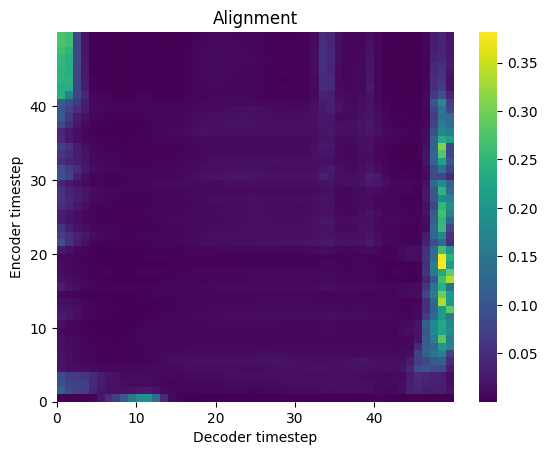

In [45]:
plot_alignment_heatmap(alignments.detach().cpu().numpy()[:1])

In [46]:
from moviepy.editor import *
import librosa
import soundfile as sf

import matplotlib.pyplot as plt

def plot_mel(S, title):
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def example_to_video(x, y, gt):
    x = x * 255.0
    x = x.astype(int)
    # C, T, H, W -> T, H, W, C
    x = x.transpose(1, 2, 3, 0)
    video = concatenate([ImageClip(f).set_duration(1/25.0) for f in x])

    S = y.transpose(1, 0)
    S = denormalize(S, hparams)
    linear_segment = librosa.feature.inverse.mel_to_stft(S, sr=hparams.sr, n_fft=hparams.n_fft)
    audio_griffin = librosa.griffinlim(linear_segment, n_iter=32, hop_length=hparams.hop_length)  # Adjust n_iter as needed
    # Save to WAV file
    sf.write('/tmp/output.wav', audio_griffin, hparams.sr)
    video.audio = AudioFileClip('/tmp/output.wav')

    # Convert to dB
    plot_mel(S, 'Output')

    print(gt.shape)
    G = gt.transpose(1, 0)
    G = denormalize(G, hparams)

    plot_mel(G, 'Ground truth')

    return video

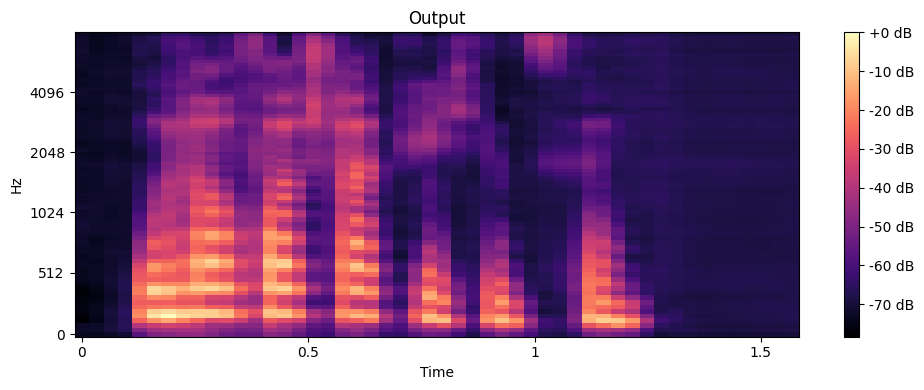

(50, 80)


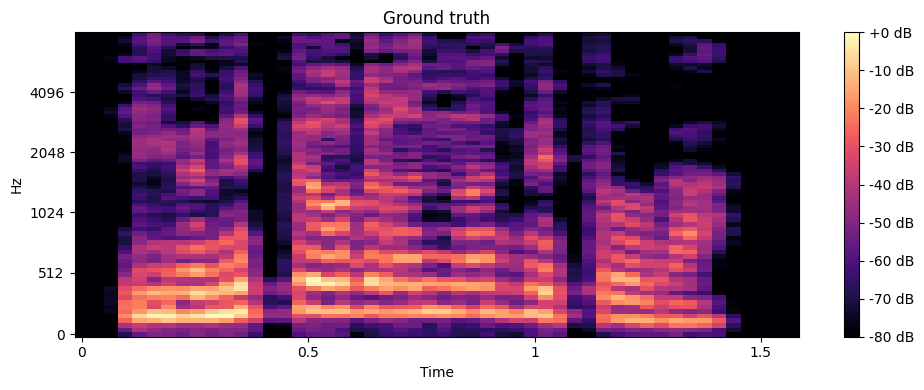

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [47]:
video = example_to_video(X[0].detach().cpu().numpy(), out[0], Y[0].detach().cpu().numpy())
video.ipython_display(width=360, fps=25)

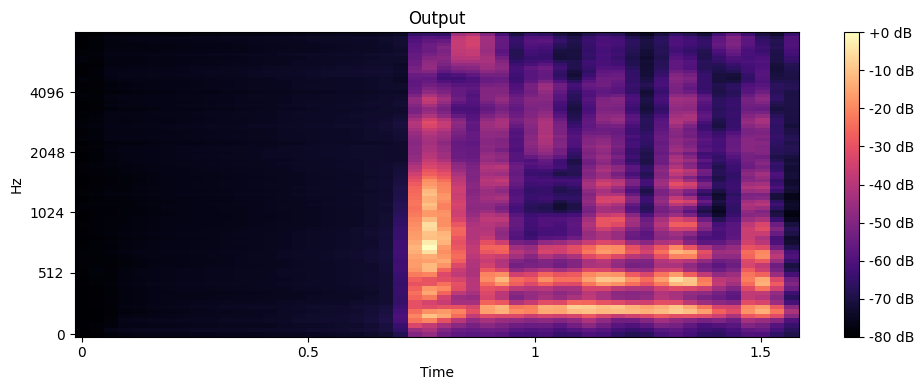

(50, 80)


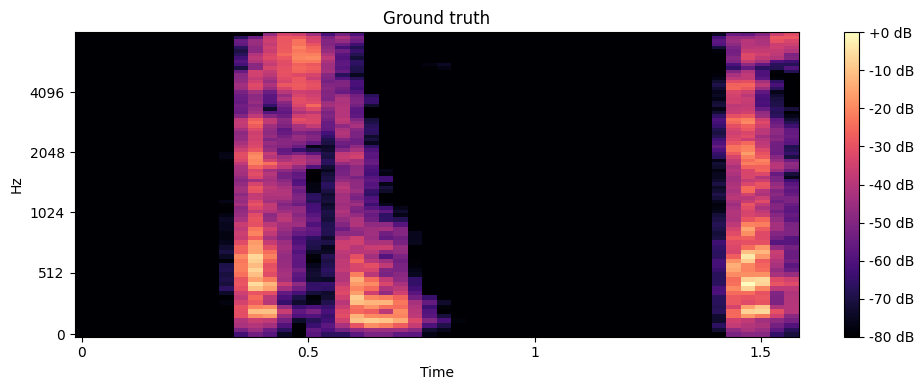

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [48]:
video = example_to_video(X[1].detach().cpu().numpy(), out[1], Y[1].detach().cpu().numpy())
video.ipython_display(width=360, fps=25)

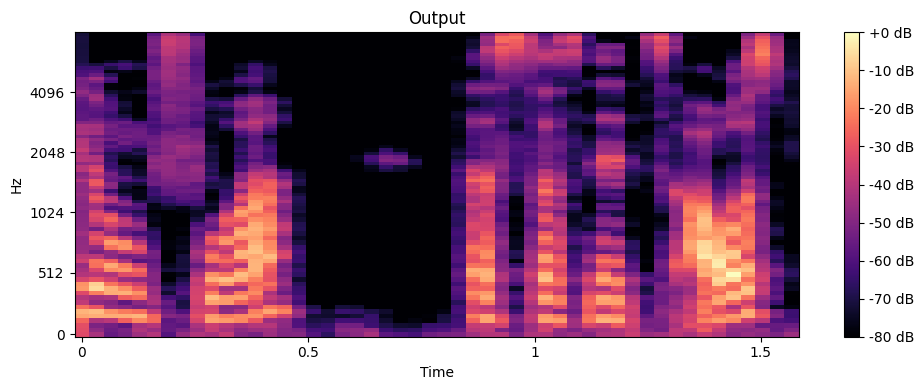

(50, 80)


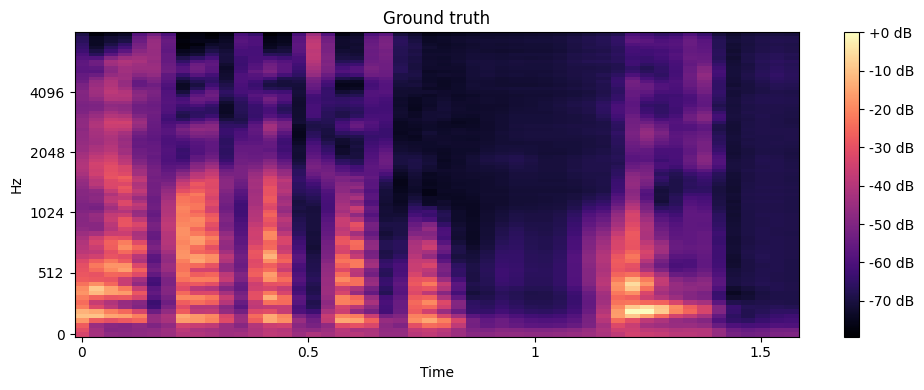

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [36]:
video = example_to_video(X[1].detach().cpu().numpy(), Y[1].detach().cpu().numpy(), out[1])
video.ipython_display(width=360, fps=25)

In [38]:
def infer_batch_to_video(X):
    out, _ = model.inference(X)
    out = out.detach().cpu().numpy()

    clips = []

    for idx, x in enumerate(X.detach().cpu().numpy()):
        x = x * 255.0
        x = x.astype(int)
        # C, T, H, W -> T, H, W, C
        x = x.transpose(1, 2, 3, 0)
        #video = concatenate([ImageClip(f).set_duration(1/25.0) for f in x])
        for f in x: clips.append(f)

        S = out[idx].transpose(1, 0)
        S = denormalize(S, hparams)

        linear_segment = librosa.feature.inverse.mel_to_stft(S, sr=hparams.sr, n_fft=hparams.n_fft)
        audio_griffin = librosa.griffinlim(linear_segment, n_iter=32, hop_length=hparams.hop_length)  # Adjust n_iter as needed
        sf.write(f'/tmp/output_{idx}.wav', audio_griffin, hparams.sr)

    # Save to WAV file
    video = concatenate([ImageClip(f).set_duration(1/25.0) for f in clips])
    video.audio = concatenate_audioclips([AudioFileClip(f'/tmp/output_{i}.wav') for i in range(X.shape[0])])
    return video

In [49]:
video = infer_batch_to_video(X[:10])
video.ipython_display(width=360, fps=25)

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
